In [193]:
import yfinance as yf
import requests
import json
import ssl
from io import StringIO
import time
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

ssl._create_default_https_context = ssl._create_stdlib_context
load_dotenv()

True

In [22]:
def get_sp500():
    url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    df = pd.read_html(url)[0][["Symbol", "Security", "GICS Sector", "GICS Sub-Industry"]]
    df.columns = ["symbol", "name", "sector", "subIndustry"]
    return df

sp500 = get_sp500()
sp500.to_csv('data/sp500.csv', index=False)
sp500

,symbol,name,sector,subIndustry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services
...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment


In [16]:
def get_sp100():
    url = 'https://en.wikipedia.org/wiki/S%26P_100'
    df = pd.read_html(url)[2][["Symbol", "Name", "Sector"]]
    df.columns = df.columns.str.lower()
    return df

# Fetch and save S&P 100 data
sp100 = get_sp100()
sp100.to_csv('data/sp100.csv', index=False)
sp100

,symbol,name,sector
0,AAPL,Apple Inc.,Information Technology
1,ABBV,AbbVie,Health Care
2,ABT,Abbott Laboratories,Health Care
3,ACN,Accenture,Information Technology
4,ADBE,Adobe Inc.,Information Technology
...,...,...,...
96,V,Visa Inc.,Information Technology
97,VZ,Verizon,Communication Services
98,WFC,Wells Fargo,Financials
99,WMT,Walmart,Consumer Staples


In [23]:
FMP_API_KEY = os.getenv('FMP_API_KEY')
JSON_SAVE_DIR = "data/balance_sheets"  # Directory to save JSON payloads

def fetch_balance_sheet(stock, limit=120):

    url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{stock}?limit={limit}&apikey={FMP_API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        with open(f"{JSON_SAVE_DIR}/{stock}_balance_sheet.json", "w") as f:
            json.dump(data, f, indent=4)
        return data
    else:
        print(f"Failed to fetch balance sheet for {stock}: {response.status_code}")
        return None

In [24]:
sp100 = pd.read_csv('data/sp100.csv')
for stock in sp100['symbol']:
    _ = fetch_balance_sheet(stock)
    print(f'fetched: {stock}')

fetched: AAPL


KeyboardInterrupt: 

In [134]:
def fetch_price_book(stock):

    url = f"https://www.macrotrends.net/stocks/charts/{stock}/ibm/price-book"

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
                       AppleWebKit/605.1.15 (KHTML, like Gecko) \
                       Chrome/100.0.4896.127 Safari/605.1.15 Firefox/100.0"
    }
    session = requests.Session()
    response = session.get(url, headers=headers)
    if response.status_code == 200:
        df = pd.read_html(StringIO(response.text))[0]
        df.columns = ["date", "price", "book_price", "price_book_ratio"]
        return df
    return None

In [28]:
sp100 = pd.read_csv('data/sp100.csv')
for stock in sp100['symbol']:
    price_book_df = fetch_price_book(stock)
    if not price_book_df is None:
        price_book_df.to_csv(f'data/price_book/{stock}_price_book.csv', index=False)
    else:
        print(f'could not fetch: {stock}')
    time.sleep(30.0)

In [27]:
def fetch_market_cap(stock):

    url = f"https://www.macrotrends.net/assets/php/market_cap.php?t={stock}"

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
                       AppleWebKit/605.1.15 (KHTML, like Gecko) \
                       Chrome/100.0.4896.127 Safari/605.1.15 Firefox/100.0"
    }
    session = requests.Session()
    response = session.get(url, headers=headers)
    if response.status_code == 200:
        html_content = response.text

        soup = BeautifulSoup(html_content, "html.parser")
        script_tags = soup.find_all("script")
        pattern = re.compile(r"var\s+chartData\s*=\s*(\[[^\]]+\]);")
        for script in script_tags:
            if script.string:
                match = pattern.search(script.string)
                if match:
                    return match.group(1)  # Extract the array part
    return None

In [28]:
sp100 = pd.read_csv('data/sp100.csv')
for stock in sp100['symbol']:
    market_cap_data = fetch_market_cap(stock)
    if not market_cap_data is None:
        with open(f"data/market_cap/{stock}_market_cap.json", "w") as f:
            json.dump(market_cap_data, f, indent=4)
        print(stock)
    else:
        print(f'could not fetch: {stock}')
    time.sleep(30.0)

GOOGL


In [51]:
# cleanse the data and save back
sp100 = pd.read_csv('data/sp100.csv')
for stock in sp100['symbol']:
    pb = pd.read_csv(f'data/price_book/{stock}_price_book.csv').dropna()
    with open(f"data/market_cap/{stock}_market_cap.json", "r") as f:
        mc = json.load(f)
        mc = json.loads(mc) # double encoded
    mc = pd.DataFrame(mc)
    mc.columns = ['date', 'market_cap']

    pb['date'] = pd.to_datetime(pb['date'])
    mc['date'] = pd.to_datetime(mc['date'])
    dfc = pd.merge_asof(pb.sort_values("date"), mc.sort_values("date"), on="date", direction="backward")
    dfc.dropna(inplace=True)
    dfc.to_csv(f'data/cleansed_data/{stock}_book_data.csv', index=False)

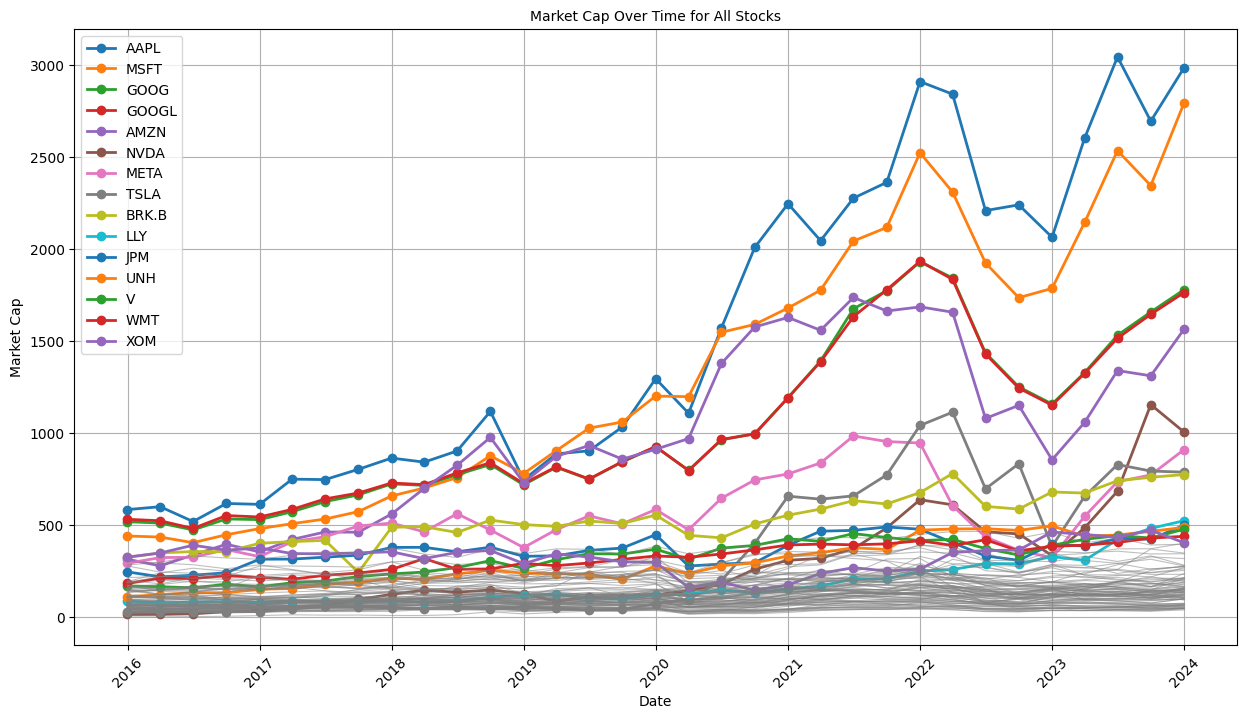

In [190]:
plt.figure(figsize=(15, 8))
all_market_caps_df = pd.DataFrame()
all_prices_df = pd.DataFrame()
all_price_to_book_df = pd.DataFrame()
sp100 = pd.read_csv('data/sp100.csv')

for stock in sp100['symbol']:
    if stock == 'DOW':
        continue
    df = pd.read_csv(f'data/cleansed_data/{stock}_book_data.csv')
    df = df[(df['date'] >= '2014-12-31') & (df['date'] <= '2023-12-31')]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df.resample('QE').last()
    df.reset_index(inplace=True)
    #df = df[df["date"].dt.month.isin([3, 6, 9, 12])] # keep quarterly data only
    df = df[(df['date'] >= '2015-12-31') & (df['date'] <= '2023-12-31')]

    market_cap_df = df[['date', 'market_cap']].copy()
    market_cap_df['stock'] = stock  # Add a stock
    market_cap_df = market_cap_df.reset_index(drop=True)
    all_market_caps_df = pd.concat([all_market_caps_df, market_cap_df], ignore_index=True)

    price_df = df[['date', 'price']].copy()
    price_df['stock'] = stock  # Add a stock
    price_df = price_df.reset_index(drop=True)
    all_prices_df = pd.concat([all_prices_df, price_df], ignore_index=True)

    price_to_book = df[['date', 'price_book_ratio']].copy()
    price_to_book['stock'] = stock  # Add a stock
    price_to_book = price_to_book.reset_index(drop=True)
    all_price_to_book_df = pd.concat([all_price_to_book_df, price_to_book], ignore_index=True)

am = all_prices_df.copy()

all_market_caps_df = all_market_caps_df.pivot(index='date', columns='stock', values='market_cap')
all_market_caps_df.ffill(inplace=True)
all_prices_df = all_prices_df.pivot(index='date', columns='stock', values='price')
all_price_to_book_df = all_price_to_book_df.pivot(index='date', columns='stock', values='price_book_ratio')

num_stocks_to_show = 15
sorted_stocks = sorted(all_market_caps_df, key=lambda stock: all_market_caps_df[stock].iloc[-1], reverse=True)

for stock in sorted_stocks[:num_stocks_to_show]:
    plt.plot(all_market_caps_df.index, all_market_caps_df[stock], label=stock, linewidth=2, marker='o')

for stock in sorted_stocks[num_stocks_to_show:]:
    plt.plot(all_market_caps_df.index, all_market_caps_df[stock], color="gray", alpha=0.5, linewidth=0.8)

plt.title('Market Cap Over Time for All Stocks', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Market Cap', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# save to disk for analysis in main notebook
all_market_caps_df.to_csv('data/sp100_market_cap.csv')
all_prices_df.to_csv('data/sp100_prices.csv')
all_price_to_book_df.to_csv('data/sp100_price_to_book.csv')

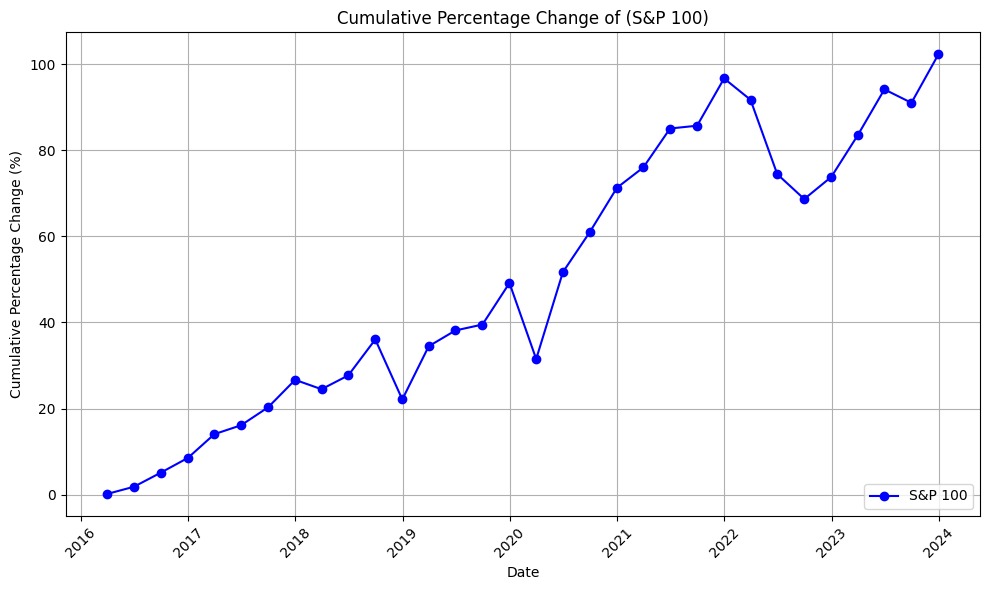

In [183]:
# Define the ticker symbol and date range
ticker_symbol = "^OEX"
start_date = "2015-12-01"
end_date = "2023-12-31"

# Fetch the data
data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1mo', progress=False)
data = data.resample('QE').last()
# Display the data
data['OEX_pct_change'] = data['Close'].pct_change() * 100
data['Cumulative_pct_change'] = data['OEX_pct_change'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Cumulative_pct_change'], marker='o', linestyle='-', color='b', label='S&P 100')
plt.title(f'Cumulative Percentage Change of (S&P 100)')
plt.xlabel('Date')
plt.ylabel('Cumulative Percentage Change (%)')
plt.grid(True)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()